<a href="https://colab.research.google.com/github/WeizmannMLcourse/MLCourse_2025/blob/main/Tutorial8_GNN/Molecule_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecule property regression with message-passing network

## Colab

### Install appropriate DGL and torch versions

- `torch`: https://pytorch.org/get-started/previous-versions/#v240
- `DGL`: https://www.dgl.ai/pages/start.html


In [ ]:
! pip3 uninstall -y torch torchvision torchaudio torchdata
! pip3 install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu124

In [ ]:
! pip3 install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html


### Initialize GitHub repo
This is to get the files besides the notebook from GitHub

(Thanks ChatGPT for code)




In [ ]:
# Clone only the specific folder using sparse checkout
!git config --global init.defaultBranch main
!git init MLCourse_2025
%cd MLCourse_2025
!git remote add origin https://github.com/WeizmannMLcourse/MLCourse_2025.git
!git config core.sparseCheckout true

# Tell Git which folder you want to pull
!echo "Tutorial8_GNN/*" >> .git/info/sparse-checkout

# Pull only the specified folder
!git pull origin main

# Go inside folder
%cd Tutorial8_GNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import dgl
from dgl.data import QM9EdgeDataset
from tqdm import tqdm

In [ ]:
%load_ext autoreload
%autoreload 2

## QM9EdgeDataset
DGL provides a preloaded interface to this dataset of 130k molecules.
- https://docs.dgl.ai/en/0.8.x/generated/dgl.data.QM9EdgeDataset.html
- http://quantum-machine.org/datasets/

We want to train a graph neural network to regress the magnitude of the electric dipole moment $|\vec{\mu}|$ of the molecule, where:

$\vec{\mu} = \sum_{i} q_i \vec{x_i}$

The atoms (nodes) in each molecule (graph) contain the following features:
- `pos`: spatial coordinates (3 numbers)
- `attr`: additional properties (11 numbers)

For our task, we will restrict ourselves to _purely_ the spatial coordinates and the atomic number as input features.

In [ ]:
data = QM9EdgeDataset(label_keys=['mu'])

Done loading data from cached files.


In [ ]:
len(data)

130831

In [ ]:
g, labels = data.__getitem__(100000)

## Plotly visualization
Code in `visualizer.py`

In [ ]:
from visualizer import draw_plotly
draw_plotly(g)

## Message-passing model
This simple graph neural network consists of three main network components:
1) Node feature encoding
2) Message passing blocks
3) Graph-level prediction

<img src="https://github.com/WeizmannMLcourse/MLCourse_2024/blob/main/Tutorial10_graphs_with_DGL/model.jpeg?raw=1">

In [ ]:
from model import MoleculeMPNN

In [ ]:
net = MoleculeMPNN()

In [ ]:
### number of parameters ###
sum(p.numel() for p in net.parameters())

371713

In [47]:
### Modified from https://docs.dgl.ai/en/0.2.x/tutorials/basics/4_batch.html ###
def collate(samples):
    '''
    This function takes a list (samples) of pairs from the dataset:
        [ (graph1, label1), (graph2, label2), ...]
    Then, in the following line we do two things at once:
        1) zip all of the pairs into two tuples:
            ( (graph1, graph2, ...), (label1, label2, ...) )
        2) convert both tuples to lists using map
    '''
    graphs, labels = map(list, zip(*samples))
    ### Combine all graphs into one big graph (bookkeeping by DGL)
    batched_graph = dgl.batch(graphs)
    ### Combine all labels into one big tensor
    labels = torch.row_stack(labels)
    return batched_graph, labels

### Train-val-test splits

In [ ]:
train_dataset = torch.utils.data.Subset(data,range(100000))
valid_dataset = torch.utils.data.Subset(data,range(100000,105000))
test_dataset = torch.utils.data.Subset(data,range(110000,len(data)-1))

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, collate_fn=collate, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=200, collate_fn=collate, num_workers=2)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, collate_fn=collate, num_workers=0)

In [ ]:
net(g)

tensor([[-0.0320]], grad_fn=<AddmmBackward0>)

## Training

In [16]:
from training import train_valid_loop

train_loss, valid_loss = train_valid_loop(net, train_dataloader, valid_dataloader, 60)

Found GPU!


  2%|▏         | 1/60 [00:36<36:21, 36.97s/it]

Epoch:  0  Train loss:  4.0644897365570065  Valid loss:  2.2584403355916343


  3%|▎         | 2/60 [01:14<35:57, 37.20s/it]

Epoch:  1  Train loss:  2.767673544883728  Valid loss:  2.2406147718429565


  5%|▌         | 3/60 [01:50<34:55, 36.76s/it]

Epoch:  2  Train loss:  2.1274080991744997  Valid loss:  1.4696317911148071


  7%|▋         | 4/60 [02:27<34:22, 36.83s/it]

Epoch:  3  Train loss:  1.8999359178543092  Valid loss:  1.2614209453264873


  8%|▊         | 5/60 [03:03<33:24, 36.45s/it]

Epoch:  4  Train loss:  1.513356397151947  Valid loss:  1.153530478477478


 10%|█         | 6/60 [03:38<32:32, 36.17s/it]

Epoch:  5  Train loss:  1.456541769504547  Valid loss:  1.1351314981778462


 12%|█▏        | 7/60 [04:16<32:19, 36.60s/it]

Epoch:  6  Train loss:  1.4027103281021118  Valid loss:  1.0964643557866414


 13%|█▎        | 8/60 [04:53<31:57, 36.87s/it]

Epoch:  7  Train loss:  1.3453425145149231  Valid loss:  1.0564716458320618


 15%|█▌        | 9/60 [05:31<31:29, 37.05s/it]

Epoch:  8  Train loss:  1.2481041312217713  Valid loss:  1.0892712275187175


 17%|█▋        | 10/60 [06:07<30:39, 36.80s/it]

Epoch:  9  Train loss:  1.2226234197616577  Valid loss:  1.0039613644282024


 18%|█▊        | 11/60 [06:43<29:46, 36.45s/it]

Epoch:  10  Train loss:  1.1919730186462403  Valid loss:  1.0532370209693909


 20%|██        | 12/60 [07:19<29:01, 36.27s/it]

Epoch:  11  Train loss:  1.1994541454315186  Valid loss:  1.0411369403203328


 22%|██▏       | 13/60 [07:55<28:21, 36.20s/it]

Epoch:  12  Train loss:  1.196097855567932  Valid loss:  1.1316949129104614


 23%|██▎       | 14/60 [08:31<27:52, 36.35s/it]

Epoch:  13  Train loss:  1.1612345576286316  Valid loss:  0.9749376773834229


 25%|██▌       | 15/60 [09:09<27:33, 36.75s/it]

Epoch:  14  Train loss:  1.12767321228981  Valid loss:  1.0221620400746663


 27%|██▋       | 16/60 [09:46<27:00, 36.82s/it]

Epoch:  15  Train loss:  1.156609869003296  Valid loss:  0.9248039722442627


 28%|██▊       | 17/60 [10:22<26:13, 36.59s/it]

Epoch:  16  Train loss:  1.1562140154838563  Valid loss:  0.9184364080429077


 30%|███       | 18/60 [10:58<25:32, 36.48s/it]

Epoch:  17  Train loss:  1.0771367120742799  Valid loss:  0.92300017674764


 32%|███▏      | 19/60 [11:35<24:55, 36.48s/it]

Epoch:  18  Train loss:  1.080990616083145  Valid loss:  0.874973992506663


 33%|███▎      | 20/60 [12:11<24:17, 36.45s/it]

Epoch:  19  Train loss:  1.0479242157936097  Valid loss:  0.9078420797983805


 35%|███▌      | 21/60 [12:47<23:39, 36.41s/it]

Epoch:  20  Train loss:  1.0340327858924865  Valid loss:  0.8888319929440817


 37%|███▋      | 22/60 [13:23<22:57, 36.25s/it]

Epoch:  21  Train loss:  1.0749562215805053  Valid loss:  0.9333874980608622


 38%|███▊      | 23/60 [14:00<22:28, 36.45s/it]

Epoch:  22  Train loss:  1.0182220804691315  Valid loss:  1.0953330000241597


 40%|████      | 24/60 [14:36<21:48, 36.34s/it]

Epoch:  23  Train loss:  1.1419435083866118  Valid loss:  0.935887614885966


 42%|████▏     | 25/60 [15:12<21:09, 36.28s/it]

Epoch:  24  Train loss:  1.0195790064334869  Valid loss:  0.8988905151685079


 43%|████▎     | 26/60 [15:48<20:25, 36.05s/it]

Epoch:  25  Train loss:  0.9808930265903473  Valid loss:  0.9309914509455363


 45%|████▌     | 27/60 [16:23<19:44, 35.88s/it]

Epoch:  26  Train loss:  0.9544931864738464  Valid loss:  0.8587908943494161


 47%|████▋     | 28/60 [16:59<19:00, 35.65s/it]

Epoch:  27  Train loss:  0.9346493291854858  Valid loss:  0.8103259404500326


 48%|████▊     | 29/60 [17:34<18:20, 35.50s/it]

Epoch:  28  Train loss:  0.9476321876049042  Valid loss:  0.7994646231333414


 50%|█████     | 30/60 [18:09<17:42, 35.41s/it]

Epoch:  29  Train loss:  0.9667165911197663  Valid loss:  0.8996896346410116


 52%|█████▏    | 31/60 [18:45<17:14, 35.67s/it]

Epoch:  30  Train loss:  0.8968829619884491  Valid loss:  0.8234937191009521


 53%|█████▎    | 32/60 [19:20<16:33, 35.50s/it]

Epoch:  31  Train loss:  0.8784099221229553  Valid loss:  0.7720271746317545


 55%|█████▌    | 33/60 [19:55<15:51, 35.25s/it]

Epoch:  32  Train loss:  0.8817964279651642  Valid loss:  0.8355639576911926


 57%|█████▋    | 34/60 [20:30<15:17, 35.29s/it]

Epoch:  33  Train loss:  0.8529977822303771  Valid loss:  0.8205305536588033


 58%|█████▊    | 35/60 [21:06<14:42, 35.29s/it]

Epoch:  34  Train loss:  0.9177802169322967  Valid loss:  0.7597306370735168


 60%|██████    | 36/60 [21:41<14:05, 35.22s/it]

Epoch:  35  Train loss:  0.8317316317558289  Valid loss:  0.7530923088391622


 62%|██████▏   | 37/60 [22:20<14:01, 36.57s/it]

Epoch:  36  Train loss:  0.8324941515922546  Valid loss:  0.7214998602867126


 63%|██████▎   | 38/60 [23:01<13:52, 37.86s/it]

Epoch:  37  Train loss:  0.8530002117156983  Valid loss:  0.7587105433146158


 65%|██████▌   | 39/60 [23:42<13:30, 38.61s/it]

Epoch:  38  Train loss:  0.7992671000957489  Valid loss:  0.7145065863927206


 67%|██████▋   | 40/60 [24:21<12:58, 38.94s/it]

Epoch:  39  Train loss:  0.8191580283641815  Valid loss:  0.6936260859171549


 68%|██████▊   | 41/60 [24:58<12:06, 38.22s/it]

Epoch:  40  Train loss:  0.7634470891952515  Valid loss:  0.6949320137500763


 70%|███████   | 42/60 [25:39<11:43, 39.07s/it]

Epoch:  41  Train loss:  0.8121183717250824  Valid loss:  0.6972945034503937


 72%|███████▏  | 43/60 [26:20<11:16, 39.79s/it]

Epoch:  42  Train loss:  0.7948473286628723  Valid loss:  0.6519293884436289


 73%|███████▎  | 44/60 [26:57<10:21, 38.84s/it]

Epoch:  43  Train loss:  0.7655852782726288  Valid loss:  0.6595553656419119


 75%|███████▌  | 45/60 [27:34<09:34, 38.33s/it]

Epoch:  44  Train loss:  0.7627171719074249  Valid loss:  0.6375752588113149


 77%|███████▋  | 46/60 [28:15<09:07, 39.11s/it]

Epoch:  45  Train loss:  0.7144270944595337  Valid loss:  0.6508837044239044


 78%|███████▊  | 47/60 [28:53<08:22, 38.66s/it]

Epoch:  46  Train loss:  0.7232412576675415  Valid loss:  0.6340426107247671


 80%|████████  | 48/60 [29:28<07:30, 37.57s/it]

Epoch:  47  Train loss:  0.7305193984508515  Valid loss:  0.6268869439760844


 82%|████████▏ | 49/60 [30:04<06:48, 37.10s/it]

Epoch:  48  Train loss:  0.6959985017776489  Valid loss:  0.6387969851493835


 83%|████████▎ | 50/60 [30:39<06:06, 36.69s/it]

Epoch:  49  Train loss:  0.701420156955719  Valid loss:  0.6470218300819397


 85%|████████▌ | 51/60 [31:15<05:26, 36.25s/it]

Epoch:  50  Train loss:  0.7355579066276551  Valid loss:  0.6537444988886515


 87%|████████▋ | 52/60 [31:49<04:46, 35.78s/it]

Epoch:  51  Train loss:  0.6770007967948913  Valid loss:  0.6356829106807709


 88%|████████▊ | 53/60 [32:24<04:08, 35.43s/it]

Epoch:  52  Train loss:  0.7177709937095642  Valid loss:  0.6226741572221121


 90%|█████████ | 54/60 [32:59<03:32, 35.39s/it]

Epoch:  53  Train loss:  0.6731872642040253  Valid loss:  0.6118277609348297


 92%|█████████▏| 55/60 [33:35<02:57, 35.52s/it]

Epoch:  54  Train loss:  0.6935284888744354  Valid loss:  0.6102329095204672


 93%|█████████▎| 56/60 [34:10<02:21, 35.37s/it]

Epoch:  55  Train loss:  0.6512059807777405  Valid loss:  0.6070322096347809


 95%|█████████▌| 57/60 [34:45<01:45, 35.21s/it]

Epoch:  56  Train loss:  0.6309857034683227  Valid loss:  0.6300577918688456


 97%|█████████▋| 58/60 [35:19<01:09, 34.91s/it]

Epoch:  57  Train loss:  0.6240772294998169  Valid loss:  0.6713654299577078


 98%|█████████▊| 59/60 [35:54<00:34, 34.89s/it]

Epoch:  58  Train loss:  0.9792856979370117  Valid loss:  0.6338834861914316


100%|██████████| 60/60 [36:29<00:00, 36.49s/it]

Epoch:  59  Train loss:  0.7397478890419006  Valid loss:  0.6244140168031057


In [17]:
### Reload stored values ###
train_loss = np.load('train_loss.npy')
valid_loss = np.load('valid_loss.npy')

In [18]:
### Load saved model ###
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<ipython-input-18-bafa0c548b29>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

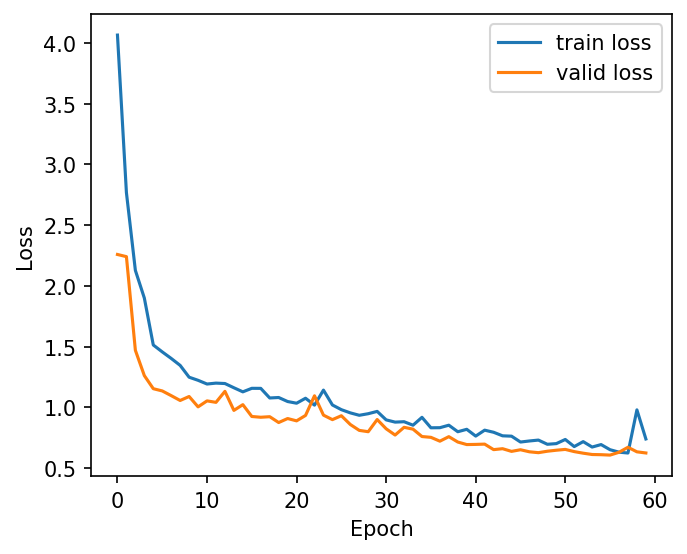

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=150)
ax.plot(range(len(train_loss)),train_loss,label='train loss')
ax.plot(range(len(valid_loss)),valid_loss,label='valid loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

## Performance evaluation

In [21]:
preds, trues = [], []

for i in tqdm(range(len(test_dataset))):
    g, labels = test_dataset.__getitem__(i)
    preds.append(net(g).detach().numpy().item())
    trues.append(labels.item())

preds = np.array(preds)
trues = np.array(trues)

100%|██████████| 20830/20830 [04:58<00:00, 69.86it/s]


### Predicted vs. true 2D density plot

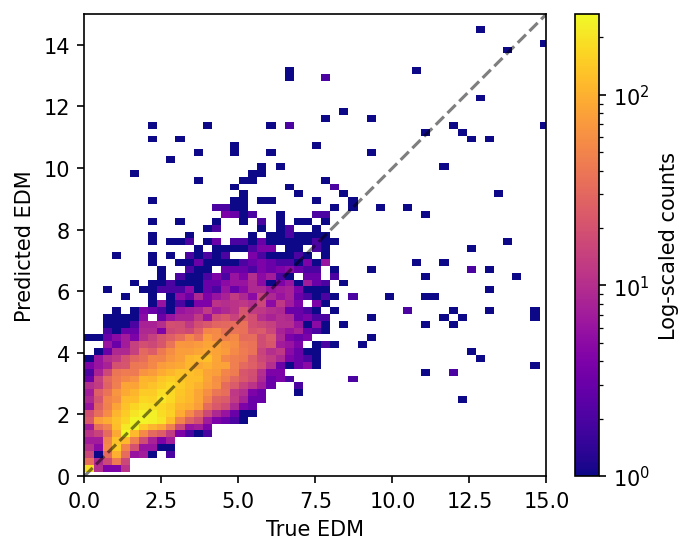

In [26]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=150)
h = ax.hist2d(
    trues,
    preds,
    bins=100,
    cmap='plasma',
    norm=LogNorm(),  # Apply log normalization
    cmin=1
)
fig.colorbar(h[3], ax=ax, label='Log-scaled counts')
ax.plot([0, 15], [0, 15], c='black', ls='--', alpha=0.5)
ax.set_xlabel('True EDM')
ax.set_ylabel('Predicted EDM')
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.set_aspect('equal')

### Residual distribution

Text(0.5, 0, '(pred - true) / true')

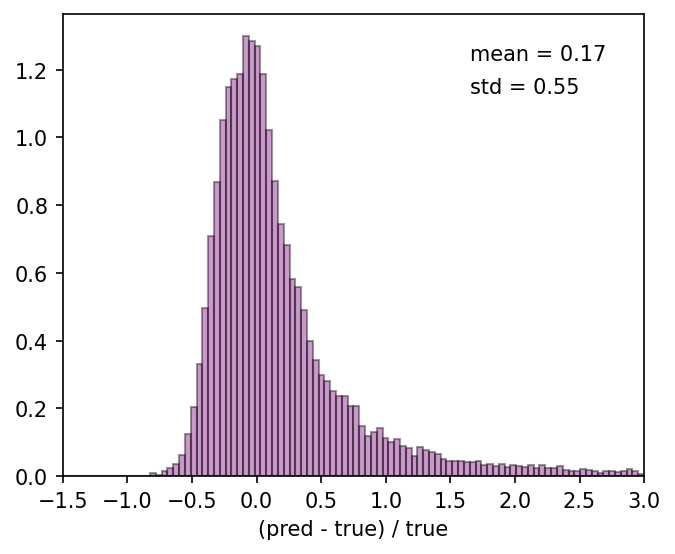

In [38]:
resids = (preds-trues)/(trues+1e-6)
resids = resids[abs(resids) < 3]

fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=150)
h = ax.hist(resids, bins=100, range=(-1.5,3), facecolor='purple', alpha=0.4, density=True, lw=1, edgecolor='black')
ax.set_xlim(-1.5, 3)
ax.text(0.7, 0.90, 'mean = {:.2f}'.format(np.mean(resids)), transform=ax.transAxes)
ax.text(0.7, 0.83, 'std = {:.2f}'.format(np.std(resids)), transform=ax.transAxes)
ax.set_xlabel('(pred - true) / true')